# Final Paper - Enhancing MELD Scores for Mortality Predictions in Liver Patients

Team: Mike Wisniewski, Alex Gregory, Henry Lambson

In this notebook, we explore alternative ways to calculate MELD scores in order to achieve better mortality predictions in liver patients.  The aim is to provide a series of models that explore what may or may not be achievable in further research.  We view that enhancement of MELD scores is crucial in order to accurately assist liver patients.  The inspiration for this exercise comes from this research paper: https://www.degruyter.com/document/doi/10.1515/labmed-2022-0162/html#j_labmed-2022-0162_ref_044, as well as years of dedication to doctors and researchers at enhancing the quality of life for liver transplant recipients.  On a personal level, Alex Gregory receives inspiration to pursue this topic from his finance who is within this domain and specialty.

Our group takes the approach of "simpler is better".  For this exercise, we view the simpler solution may be the best solution - not because solving medical problems is easy, but because the data surrounding this topic is limited in number of records (patients).  Therefore, with this limitation, we believe there is no need for overly complex neural networks.  But we do think that neural networks still play an important role in determining MELD scores.

This notebook aims to explore 6 types of models:
- A simple sequential neural network with 8 Dense layers (with some dropout/normalization), a glorot uniform weight distribution, and relu activations in the hidden layers with a linear output layer for regression analysis
- The same model described above with PCA preprocessing
- The same model descibed above with UMAP preprocessing
- A complex model based on ResNet that aims to provide an example of a model too complicated for this use case
- Our ResNet model with PCA preprocessing
- Our ResNet model with UMAP preprocessing

Our aim is to provide an analysis of the MELD score distributions among 5 buckets (as described later in this notebook), and to compare the output of the above models with:
- Traditionally calculated MELD scores
- MELD3 scores
- MELDNA scores
- A cross analysis with the above referenced research paper and it's results of MELD scores

This notebook also aims to provide as a supplement to our research paper on this topic.  For most sections, explanations will be given, but the most important details will be extracted and used within our paper.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import seaborn as sns
import umap

from tensorflow import Tensor
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, ReLU, BatchNormalization, Add, Flatten, Dense, GlobalAveragePooling1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from scipy.stats import ttest_rel
from scipy.stats import t

pd.options.display.max_columns = 100

## Utility Functions

Our Sequential Model contains 8 dense layers which we found to be the limit as to how complex we wanted to create our model.  Additionally, there are some dropout and normalization layers.  For droupout, we dropout slightly heavier than normal dropouts because of the size of our dataset creates significant overfittings when running without dropout.  We add in batchnormalization to .....  Adam with a conservative learning rate is used.  Altering the learning rate did not improve or reduce overall loss and performance.  We use a Mean Squared Error loss for our model.  We track MSE, MAE, and MSLE as our metrics to assess overall performance of the model.

In [2]:
def create_sequential_model(df):
    input_shape = len(df[0])
    
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,), kernel_initializer="glorot_uniform"),
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(16, activation='relu'),
        BatchNormalization(),
        Dense(8, activation='relu'),
        Dense(1, activation='linear')  # Output layer with linear activation
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=["mae", "msle"])

    return model

Our ResNet model acts as our Complex model we will be using for our testing.  This is influenced by this paper: <INSERT PAPER> where it is theorized that transfer learning could be used to predict MELD scores. We did not set out on transfer learning, but we did adopt a simpler architecture of ResNet (which we modified slightly to include dropouts).  Dropout is at 50% to reduce drastic overfitting we observed when testing our models.  Typical 20% Dropout was not working in the model favor when assessing overfitting.

In [3]:
def relu_bn(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv1D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Dropout(.5)(y)
    y = Conv1D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)
    y = relu_bn(y)
    if downsample:
        x = Conv1D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
        x = relu_bn(x)

    out = Add()([x, y])
    
    return out

def create_res_net(df, num_filters=64):

    # input layer
    inputs = Input(shape=(df.shape[1], 1))

    # first conv layer
    t = Conv1D(kernel_size=3,
               strides=1,
               filters=num_filters,
               padding="same")(inputs)
    t = BatchNormalization()(t)
    t = relu_bn(t)
    t = Dropout(.5)(t)
    t = MaxPooling1D(pool_size=3, strides=2, padding='same')(t)
    
    # residual blocks
    num_blocks_list = [2, 5, 5, 2]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample=(j==0 and i!=0), filters=num_filters)
        num_filters *= 2

    # output of residual blocks to pooling
    t = GlobalAveragePooling1D()(t)

    # flatten pool
    t = Flatten()(t)

    # fully connected network
    t = Dense(64, activation="relu", kernel_initializer="glorot_uniform")(t)
    f1 = Dense(32, activation="relu")(t)
    f2 = Dense(16, activation="relu")(f1)
    f3 = Dense(8, activation="relu")(f2)

    # output layer
    outputs = Dense(1, activation='linear')(f3)

    # model compilations
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=["mae", "msle"])
    
    return model    

meld_acc is defined to assess the mortality rates within each MELD bin.  These bins are defined in the linked paper above (Sebastian Gibb, Thomas Berg, Adam Herber, Berend Isermann and Thorsten Kaiser).  These bins are hardcoded in the below function.  The idea behind this calculation is to provide some sense of "accuracy" with our regression outputs, as typical metrics used to assess regression are errors such as MSE, MAE, and MSLE (as described above).

In [4]:
def meld_acc(df, meld_column):
    mortality_rate = []

    bracket_1_deceased = df[(df[meld_column] <= 9) & (df["Deceased"] == 1)]
    bracket_1_nondeceased = df[(df[meld_column] <= 9) & (df["Deceased"] == 0)]

    bracket_2_deceased = df[(df[meld_column] <= 20) & (df[meld_column] > 9) & (df["Deceased"] == 1)]
    bracket_2_nondeceased = df[(df[meld_column] <= 20) & (df[meld_column] > 9) & (df["Deceased"] == 0)]

    bracket_3_deceased = df[(df[meld_column] <= 30) & (df[meld_column] > 20) & (df["Deceased"] == 1)]
    bracket_3_nondeceased = df[(df[meld_column] <= 30) & (df[meld_column] > 20) & (df["Deceased"] == 0)]

    bracket_4_deceased = df[(df[meld_column] <= 40) & (df[meld_column] > 30) & (df["Deceased"] == 1)]
    bracket_4_nondeceased = df[(df[meld_column] <= 40) & (df[meld_column] > 30) & (df["Deceased"] == 0)]

    bracket_5_deceased = df[(df[meld_column] > 40) & (df["Deceased"] == 1)]
    bracket_5_nondeceased = df[(df[meld_column] > 40) & (df["Deceased"] == 0)]

    try:
        bracket_1_mortality_rate = len(bracket_1_deceased) / (len(bracket_1_deceased) + len(bracket_1_nondeceased))
    except ZeroDivisionError:
        bracket_1_mortality_rate = 0
    
    try:
        bracket_2_mortality_rate = len(bracket_2_deceased) / (len(bracket_2_deceased) + len(bracket_2_nondeceased))
    except ZeroDivisionError:
        bracket_2_mortality_rate = 0

    try:
        bracket_3_mortality_rate = len(bracket_3_deceased) / (len(bracket_3_deceased) + len(bracket_3_nondeceased))
    except ZeroDivisionError:
        bracket_3_mortality_rate = 0

    try:
        bracket_4_mortality_rate = len(bracket_4_deceased) / (len(bracket_4_deceased) + len(bracket_4_nondeceased))
    except ZeroDivisionError:
        bracket_4_mortality_rate = 0

    try:
        bracket_5_mortality_rate = len(bracket_5_deceased) / (len(bracket_5_deceased) + len(bracket_5_nondeceased))
    except ZeroDivisionError:
        bracket_5_mortality_rate = 0

    mortality_rate.append(bracket_1_mortality_rate)
    mortality_rate.append(bracket_2_mortality_rate)
    mortality_rate.append(bracket_3_mortality_rate)
    mortality_rate.append(bracket_4_mortality_rate)
    mortality_rate.append(bracket_5_mortality_rate)

    return mortality_rate

In [5]:
def widths(df, meld_column):
    widths = []

    bracket_1_width = len(df[(df[meld_column] <= 9) & (df["Deceased"] == 1)])

    bracket_2_width = len(df[(df[meld_column] <= 20) & (df[meld_column] > 9) & (df["Deceased"] == 1)])

    bracket_3_width = len(df[(df[meld_column] <= 30) & (df[meld_column] > 20) & (df["Deceased"] == 1)])

    bracket_4_width = len(df[(df[meld_column] <= 40) & (df[meld_column] > 30) & (df["Deceased"] == 1)])

    bracket_5_width = len(df[(df[meld_column] > 40) & (df["Deceased"] == 1)])

    widths.append(bracket_1_width)
    widths.append(bracket_2_width)
    widths.append(bracket_3_width)
    widths.append(bracket_4_width)
    widths.append(bracket_5_width)

    return widths

The following are MELD functions used to assist in calculating the overall MELD scores defined later.  These calculations can be found here: https://www.mdcalc.com/calc/10437/model-end-stage-liver-disease-meld#evidence

In [6]:
# meld functions

# TODO: check all SI values and see what needs conversion. Sodium did not, unknown after Bili but placeholder functions added
#convert SI units to US units

# creatinine umol/L to mg/dl
def convertCreatinine(CRE_S):
     return (CRE_S * 0.0230)

# bilirubin umol/L to mg/dl
def convertBilirubin(BILI_S):
     return (BILI_S * 0.0585)

# cystatinc umol/L to mg/dl
def convertCystatinC(BILI_S):
     return (BILI_S * 0.0585)

# il6 umol/L to mg/dl
def convertIL_6(BILI_S):
     return (BILI_S * 0.0585)

# wbc umol/L to mg/dl
def convertWBC(BILI_S):
     return (BILI_S * 0.0585)

# bilirubin umol/L to mg/dl
def convertProtien(BILI_S):
     return (BILI_S * 0.0585)

def convertAlbumin(BILI_S):
     return (BILI_S * 0.0585)

def convertALAT(BILI_S):
     return (BILI_S * 0.0585)

def convertASAT(BILI_S):
     return (BILI_S * 0.0585)

# meld3
# 1.33*(Female) + 4.56*ln(Serum bilirubin) + 0.82*(137 - Sodium) – 0.24*(137 - Sodium)*ln(Serum bilirubin) + 9.09*ln(INR) + 11.14*ln(Serum creatinine) + 1.85*(3.5 – Serum albumin) – 1.83*(3.5 – Serum albumin)*ln(Serum creatinine) + 6,
# rounded to the nearest integer

# Serum bilirubin, INR, and serum creatinine values below 1.0 are set to 1.0.
# Sodium is limited to a range of 125-137 mEq/L, and if outside of these bounds, is set to the nearest limit.
# Serum albumin is limited to a range of 1.5-3.5 g/dL, and if outside of these bounds, is set to the nearest limit.
# Maximum serum creatinine is 3.0 mg/dL, and if above this bound, is set to 3.0 mg/dL.

def calm_meld(CRE_S, BILI_S, INR_C):
    meld_score = (0.957*math.log(convertCreatinine(CRE_S)) + 0.378*math.log(convertBilirubin(BILI_S)) + 1.120*math.log(INR_C) + 0.643)*10
    return int(round(meld_score))

def calc_meld3(CRE_S, BILI_S, INR_C, NA_S, ALB_S, sex):
    BILI_S = convertBilirubin(BILI_S)
    CRE_S = convertCreatinine(CRE_S)
    if BILI_S < 1:
        BILI_S = 1
    if INR_C < 1:
        INR_C = 1
    if CRE_S < 1:
        CRE_S = 1
    if CRE_S >= 3:
        CRE_S = 3
    if NA_S > 137:
        NA_S = 137
    if NA_S < 125:
        NA_S = 125
    if ALB_S > 3.5:
        ALB_S = 3.5
    if ALB_S < 1.5:
        ALB_S = 1.5
    if sex == 'female':
        sex = 1
    else:
        sex = 0
    
    meld3_score = 1.33*(sex) + 4.56*math.log(BILI_S) + 0.82*(137 - NA_S) - 0.24*(137 - NA_S)*math.log(BILI_S) + 9.09*math.log(INR_C) + 11.14*math.log(CRE_S) + 1.85*(3.5 - ALB_S) - 1.83*(3.5 - ALB_S)*math.log(CRE_S) + 6
    return int(round(meld3_score))

# meld_na
# MELD(i) = 0.957*ln(Creatinine) + 0.378*ln(Bilirubin) + 1.120*ln(INR) + 0.643
# Then, round to the tenth decimal place and multiply by 10. 
# If MELD(i) > 11, perform additional MELD calculation as follows:
# MELD = MELD(i) + 1.32*(137 – Na) –  [0.033*MELD(i)*(137 – Na)]

def calc_meldNA(CRE_S, BILI_S, INR_C,NA_S):
    meldNA_score = 0.957 * math.log(convertCreatinine(CRE_S)) + 0.378*math.log(convertBilirubin(BILI_S)) + 1.120*math.log(INR_C) + 0.643
    meldNA_score = round(meldNA_score, 1) * 10
    if meldNA_score > 11:
        meldNA_score = meldNA_score + 1.32*(137-NA_S) - (0.033*meldNA_score*(137-NA_S))
    return int(round(meldNA_score))


## Data Preprocessing

In [7]:
# read in data
df = pd.read_csv("liverData/eldd.csv")

In [8]:
# print length and show sample data
print(len(df))
df.head()

654


,Age,Sex,DaysAtRisk,Deceased,LTx,Cirrhosis,ALF,Ethyltoxic,HBV,HCV,AIH,PBC,PSC,NASH,Cryptogenic,Dialysis,GIB,HCC,SBP,ALAT_S,ALB_S,AP_S,ASAT_S,B_MPV_E,B_PLT_E,B_WBC_E,BILI_S,BILID_S,CA_S,CHE_S,CHOLG_S,CL_S,CRE_S,CRP_S,CYSC_S,GGT_S,IL6_S,INR_C,NA_S,P_S,PALB_S,PROT_S,PTH_S,VDT_OH_S
0,68,male,200,0,0,1.0,0,1,1,0,0,0,0,0,0,0.0,0,1,0.0,0.29,40.9,1.17,0.56,11.0,160.0,7.4,7.9,3.5,2.17,74.6,3.08,100.3,104,8.20,1.79,1.97,22.87,1.11,135.4,1.49,0.19,69.6,2.39,12.7
1,64,male,3,1,0,1.0,0,1,0,0,0,0,0,0,0,0.0,1,0,0.0,0.22,28.3,3.68,0.66,NaN,10.0,8.1,43.2,26.0,2.04,14.7,2.21,101.9,304,43.54,4.87,2.43,336.50,1.77,133.1,0.96,0.05,62.5,19.39,5.5
2,67,female,208,0,0,1.0,0,1,0,0,0,0,0,0,0,0.0,0,0,0.0,0.19,41.7,1.50,0.68,10.8,123.0,4.9,16.9,6.9,2.33,59.5,5.02,93.8,95,9.88,2.23,1.84,16.74,1.09,137.4,1.14,0.17,80.5,7.39,18.8
3,32,female,17,1,0,0.0,1,0,0,0,0,0,0,0,0,0.0,0,0,0.0,0.78,23.8,52.97,3.24,NaN,NaN,NaN,266.5,208.3,2.23,15.4,4.55,95.7,61,90.29,4.73,24.35,709.80,2.29,130.5,1.71,0.15,48.9,2.21,4.5
4,64,female,189,0,0,1.0,0,1,0,0,0,0,0,0,0,0.0,1,0,0.0,0.75,36.3,2.79,1.33,13.9,65.0,6.3,37.2,16.9,2.28,63.8,4.78,100.8,73,8.65,1.51,2.45,7.90,1.10,142.6,1.07,0.11,67.6,4.17,34.1


It is necessary to drop any known records where INR_C, NA_S, or ALB_S is null because null values are not compatible with MELD, and we can not assume 0 for these values.

In [9]:
#TODO: convert SI to metric as necessary
# drop NA rows to allow for meld scores. 654 down to 638
df = df.dropna(subset=['INR_C','NA_S','ALB_S'])

We create a reset point here when we were running the model.  It is not required to have df2 = df.copy... but we added this to ensure we don't have to rerun the entire notebook when model testing.

Additionally, we calculate the MELD, MELD3, and MELDNA scores

In [10]:
# MELD calculations
df2 = df.copy(deep=True).reset_index(drop=True)
df2['MELD'] = df2.apply(lambda row: calm_meld(row["CRE_S"],row["BILI_S"],row["INR_C"]), axis =1)
df2['MELD3'] = df2.apply(lambda row: calc_meld3(row["CRE_S"],row["BILI_S"],row["INR_C"],row["NA_S"],row["ALB_S"],row["Sex"]), axis =1)
df2['MELDNA'] = df2.apply(lambda row: calc_meldNA(row["CRE_S"],row["BILI_S"],row["INR_C"],row["NA_S"]), axis =1)

Additional preprocessing includes one-hot encoding Sex (which is our only qualitative variable), replacing remaining null values with 0 as we view other columns that are not INR_C, NA_S, or ALB_S as safe to assume a null is equivalent to 0, and scale the final dataframe used to run through the model.  Not shown here, but pre-model assessment was done to see what scaling would be appropriate.  Most continuous values have few, if any, extreme outliers and therefore a Standard Scaler is used over something like a Robust Scaler.  Note: scaling is only occuring on non-binary columns.  It is not necessary to scale and normalize binary columns for our use case.  We separate target and feature scalers as two entities so as to not influence the scaling of one over the other.

In [11]:
# one-hot encode Sex
col = pd.get_dummies(df2['Sex'])
del df2['Sex']
df2 = df2.join(col)

# take out MELD score comparisons for final_df
final_df = df2.copy(deep=True)

# Assumption: all null numeric values are 0
final_df = final_df.replace(np.NaN, 0)

# initialize the scaler
final_df_normalized = final_df.copy(deep=True)

feature_scaler = StandardScaler()
target_scaler = StandardScaler()
non_binary_cols = [col for col in final_df.columns if len(final_df[col].unique()) > 2]
non_binary_cols.remove("MELD")
non_binary_cols.remove("MELD3")
non_binary_cols.remove("MELDNA")
binary_cols = [col for col in final_df.columns if len(final_df[col].unique()) <= 2]

We create our X and y datasets.  For this analysis, we will try to calculate based on traditional MELD, but other MELD variants are acceptable - the final analysis would be different given the context of those scores.  After creating our X and y datasets, we normalize and scale the data accordingly with the pre-defined scalers above.

In [12]:
# target MELD, but can switch out for any other MELD variant
y = final_df_normalized['MELD'].copy(deep=True)
y = target_scaler.fit_transform(np.array(y).reshape(-1, 1))

# X dataset should not include MELD scores and should be scaled at this point
X = final_df_normalized.copy(deep=True)
X = X.drop(["MELD", "MELD3", "MELDNA"], axis=1)
X_non_binary = pd.DataFrame(feature_scaler.fit_transform(X[non_binary_cols]), columns=non_binary_cols)
X = pd.concat([X[binary_cols], X_non_binary], axis=1)

# set model variables
test_size = 0.3
random_state = 7
epochs = 500
verbose = 0
batch_size = 32

## Model 1: MELD Prediction with Typical Data Preprocessing

We convert our data into Tensors because we found this makes our model faster and creates better results (somehow).

Our test size is 30%.  Typically, we like to have larger validation sizes in order to compensate for smaller datasets.  We found that 30% worked fine for our use case, but we did not optimize for this step as we believe that no amount of changing this variable would cause massive differences due to the limited N-size of 638 records.  We control for a random state so that our results will always be the same.  We run for 500 epochs, but this could be increased because both loss and validation losses still decrease although with diminishing returns.  Batch size is 32 because of the limited amount of data.

In [13]:
# split X, y
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(X, y, test_size=test_size, random_state=random_state)
X_train_seq = tf.convert_to_tensor(X_train_seq)
X_test_seq = tf.convert_to_tensor(X_test_seq)
y_train_seq = tf.convert_to_tensor(y_train_seq)
y_test_seq = tf.convert_to_tensor(y_test_seq)

In [14]:
# initialize and fit sequential model
sequential_model = create_sequential_model(df=X_train_seq)
sequential_model.fit(x=X_train_seq,
    y=y_train_seq,
    epochs=epochs,
    verbose=verbose,
    validation_data=(X_test_seq, y_test_seq),
    batch_size=batch_size)

Analysis: The model appears to not overfit in terms of loss.  This is reassuring as we initially feared some overfitting would occur due to the limited data size.  Additionally, the loss metrics themselves are at healthy levels hovering 0.1, 0.2, and 0.01 respectively.  Each of these are relatively good considering our limitations.  It is worthy to note that this model could run for another 500 epochs before it starts to level out on loss.

Text(0, 0.5, 'Loss')

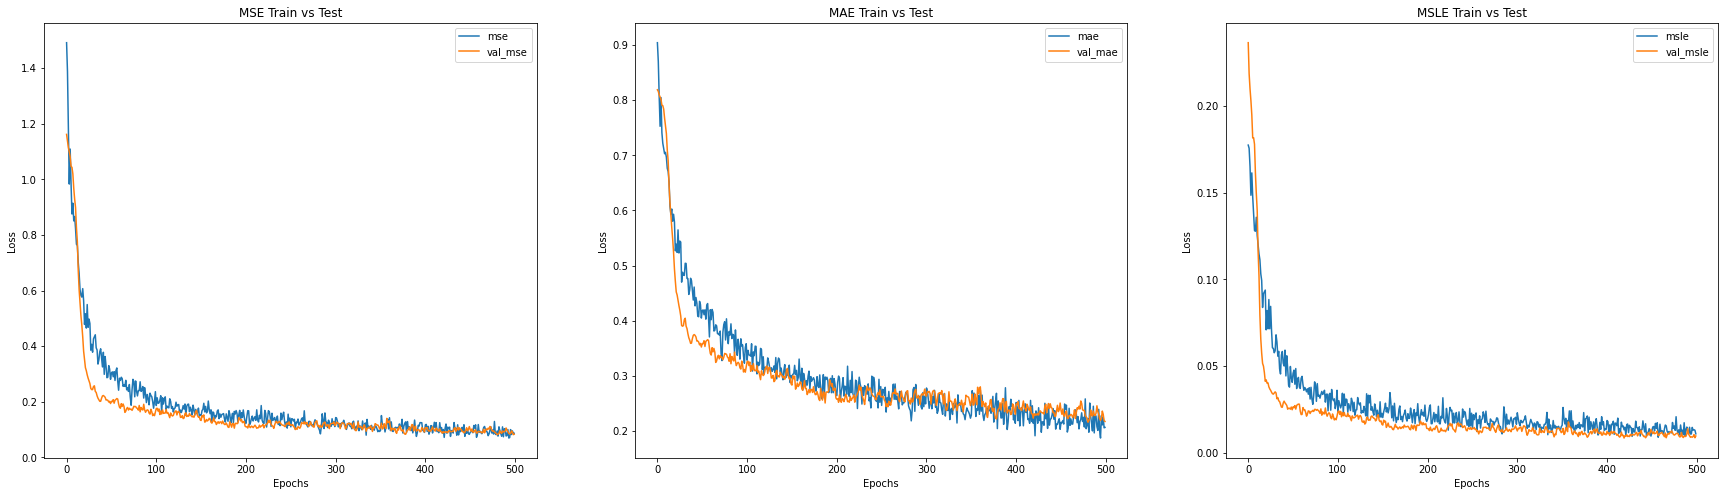

In [15]:
# plot out model 1 loss metrics
mse = sequential_model.history.history["loss"]
mae = sequential_model.history.history["mae"]
msle =  sequential_model.history.history["msle"]
val_mse = sequential_model.history.history["val_loss"]
val_mae = sequential_model.history.history["val_mae"]
val_msle =  sequential_model.history.history["val_msle"]

fig, ax = plt.subplots(1, 3, figsize=(30, 8))
ax[0].plot(mse)
ax[0].plot(val_mse)
ax[0].legend(["mse", "val_mse"])
ax[0].set_title("MSE Train vs Test")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")

ax[1].plot(mae)
ax[1].plot(val_mae)
ax[1].legend(["mae", "val_mae"])
ax[1].set_title("MAE Train vs Test")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

ax[2].plot(msle)
ax[2].plot(val_msle)
ax[2].legend(["msle", "val_msle"])
ax[2].set_title("MSLE Train vs Test")
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("Loss")

In [16]:
# predict out values
y_pred_seq = sequential_model.predict(X_test_seq)

# reverse scaling
y_pred_seq = np.round(target_scaler.inverse_transform(np.array(y_pred_seq)))
y_test_seq = np.round(target_scaler.inverse_transform(np.array(y_test_seq)))


Analysis: per traditional MELD scores, it seems patients centered around the 15 - 17 MELD score range, suggesting that these were the most common type of patients.  With the newly predicted MELD scores, more patients are beginning to reclassify into lower scores, as the number of higher scores (25+) has decreased.

Text(0, 0.5, 'Number of Patients')

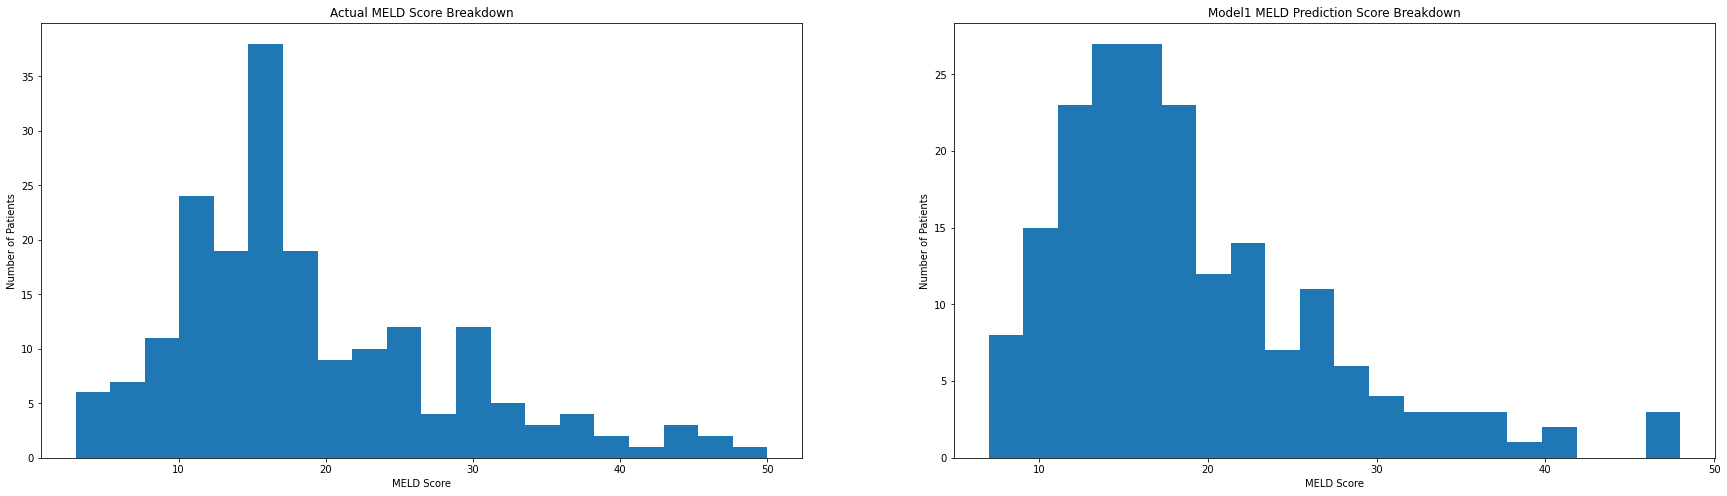

In [17]:
# MELD distribution breakdown
fig, ax = plt.subplots(1, 2, figsize=(30, 8))

ax[0].hist(np.array(y_test_seq), bins=20)
ax[0].set_title("Actual MELD Score Breakdown")
ax[0].set_xlabel("MELD Score")
ax[0].set_ylabel("Number of Patients")

ax[1].hist(y_pred_seq, bins=20)
ax[1].set_title("Model1 MELD Prediction Score Breakdown")
ax[1].set_xlabel("MELD Score")
ax[1].set_ylabel("Number of Patients")

In [18]:
# create meld prediction dataframe to calculate accuracies
meld_predictions_seq = pd.concat([pd.DataFrame(data=np.array(X_test_seq), columns=X.columns), pd.DataFrame(data=np.array(y_pred_seq), columns=["MELD_Prediction_SEQ"])], axis=1)
prediction_accuracy_seq = meld_acc(meld_predictions_seq, meld_column="MELD_Prediction_SEQ")

In [19]:
# create MELD dataset used for further analysis in the final section
meld_predictions = pd.concat([pd.DataFrame(data=np.array(X_test_seq), columns=X.columns), pd.DataFrame(data=np.array(y_test_seq), columns=["MELD"])], axis=1)
MELD_acc_expected = meld_acc(meld_predictions, meld_column="MELD")
meld_width_expected = widths(meld_predictions, meld_column="MELD")

## Model 2: MELD Prediction with PCA Dimensionality Reduction

The following model utilizes PCA to reduce our dimensions.  We choose a reduction to 12 PCA components as 12 components explains roughly 80% of the variance.  We highlight that explained variance is important at creating a healthy model.  We follow the 80/20 rule so long as the dimensions reduced to were meaningful (27 continuous columns -> 12 PCA components).  Note: we only PCA transform on continuous columns because when inverse transforming binary columns, we did not receive binary values back, which made tracking MELD score breakdowns much more difficult.  Therefore, we only PCA transform on continuous columns and keep the binary columns separate (but still include into our dataset)

Additionally, we also scale our dataset before PCA transformation.  Scaling is important because without it, only 1 PCA component explained 99% of the variance.

In [20]:
# initialize PCA and scale accordingly
pca = PCA(n_components=12)
scaler = StandardScaler()
X = final_df_normalized.copy(deep=True)
X = X.drop(["MELD", "MELD3", "MELDNA"], axis=1)
non_binary_cols_pca = [col for col in X.columns if len(X[col].unique()) > 2]
binary_cols_pca = [col for col in X.columns if len(X[col].unique()) <= 2]
X_non_binary_pca = pd.DataFrame(scaler.fit_transform(X[non_binary_cols_pca]), columns=non_binary_cols_pca)
X_non_binary_pca = pd.DataFrame(pca.fit_transform(X_non_binary_pca))
X_pca = pd.concat([X[binary_cols_pca], X_non_binary_pca], axis=1)

print(f"Sum of the Explained Variance for the chosen PCA Components: {sum(pca.explained_variance_ratio_)}")

Sum of the Explained Variance for the chosen PCA Components: 0.7943703705213259


This isn't meaningful analysis, but is good to view how the 2 highest PCA components interact with eachother.  A near horizontal line indicates that PCA1 captures more explained variance than PCA2 - as expected.  There is some healthy distributions as PC1 increases, so does the variance in PC2.

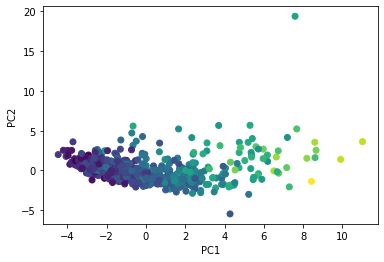

In [21]:
plt.scatter(X_pca[0], X_pca[1], c=y)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [22]:
# split X, y
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=test_size, random_state=random_state)
X_train_pca = tf.convert_to_tensor(X_train_pca)
X_test_pca = tf.convert_to_tensor(X_test_pca)
y_train_pca = tf.convert_to_tensor(y_train_pca)
y_test_pca = tf.convert_to_tensor(y_test_pca)

In [23]:
# initialize and fit sequential model
sequential_model_pca = create_sequential_model(df=X_train_pca)
sequential_model_pca.fit(x=X_train_pca,
    y=y_train_pca,
    epochs=epochs,
    verbose=0,
    validation_data=(X_test_pca, y_test_pca),
    batch_size=batch_size)

There is slight overfitting but as expected with minimal data.  These same observations have been described within the first model, except overfitting starts to occur after the 100th epoch.  The loss scores themselves are comprable to Model 1.  There may be a case to be made that a different model architecture needs to be used for PCA due to overfitting.

Text(0, 0.5, 'Loss')

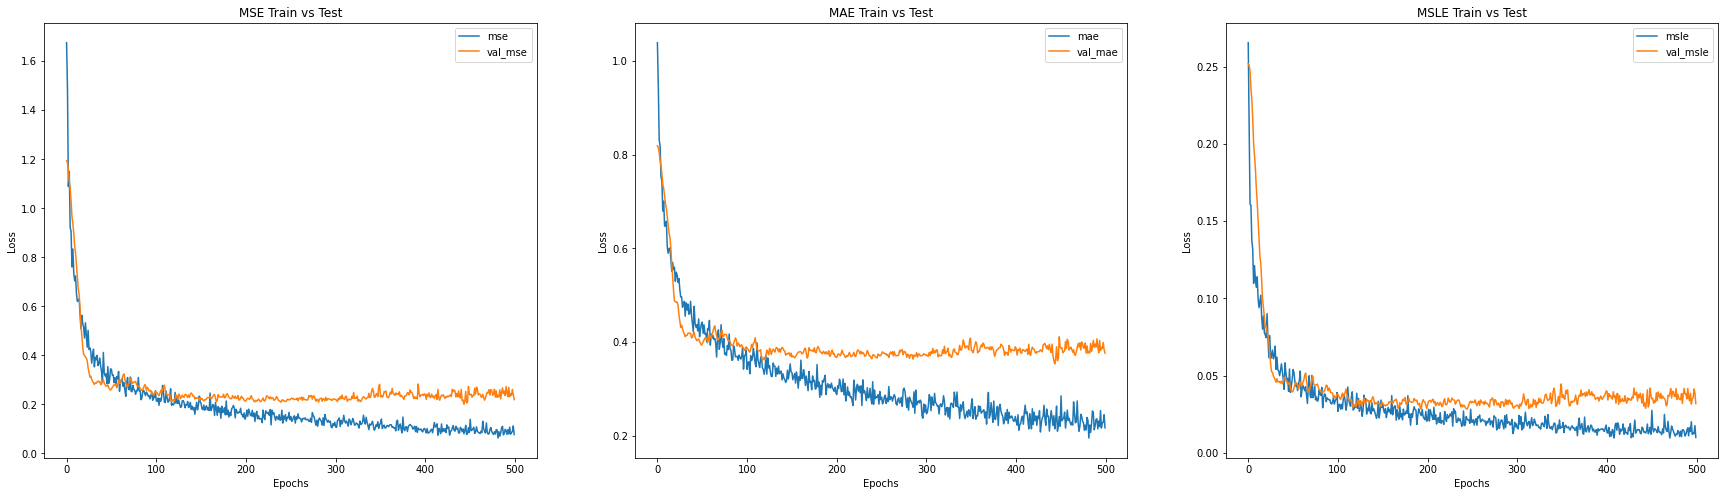

In [24]:
# plot out loss vs validation
pca_mse = sequential_model_pca.history.history["loss"]
pca_mae = sequential_model_pca.history.history["mae"]
pca_msle =  sequential_model_pca.history.history["msle"]
pca_val_mse = sequential_model_pca.history.history["val_loss"]
pca_val_mae = sequential_model_pca.history.history["val_mae"]
pca_val_msle =  sequential_model_pca.history.history["val_msle"]

fig, ax = plt.subplots(1, 3, figsize=(30, 8))
ax[0].plot(pca_mse)
ax[0].plot(pca_val_mse)
ax[0].legend(["mse", "val_mse"])
ax[0].set_title("MSE Train vs Test")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")

ax[1].plot(pca_mae)
ax[1].plot(pca_val_mae)
ax[1].legend(["mae", "val_mae"])
ax[1].set_title("MAE Train vs Test")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

ax[2].plot(pca_msle)
ax[2].plot(pca_val_msle)
ax[2].legend(["msle", "val_msle"])
ax[2].set_title("MSLE Train vs Test")
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("Loss")

In [25]:
# predict out values
y_pred_seq_pca = sequential_model_pca.predict(X_test_pca)

# reverse scaling
y_pred_seq_pca = np.round(target_scaler.inverse_transform(np.array(y_pred_seq_pca)))
y_test_pca = np.round(target_scaler.inverse_transform(np.array(y_test_pca)))


Similar to the first model, the PCA implementation of this model also reclassifies a lot of the higher MELD scores to lower MELD scores.  More patients are reclassified between the 15 - 17 MELD range

Text(0, 0.5, 'Number of Patients')

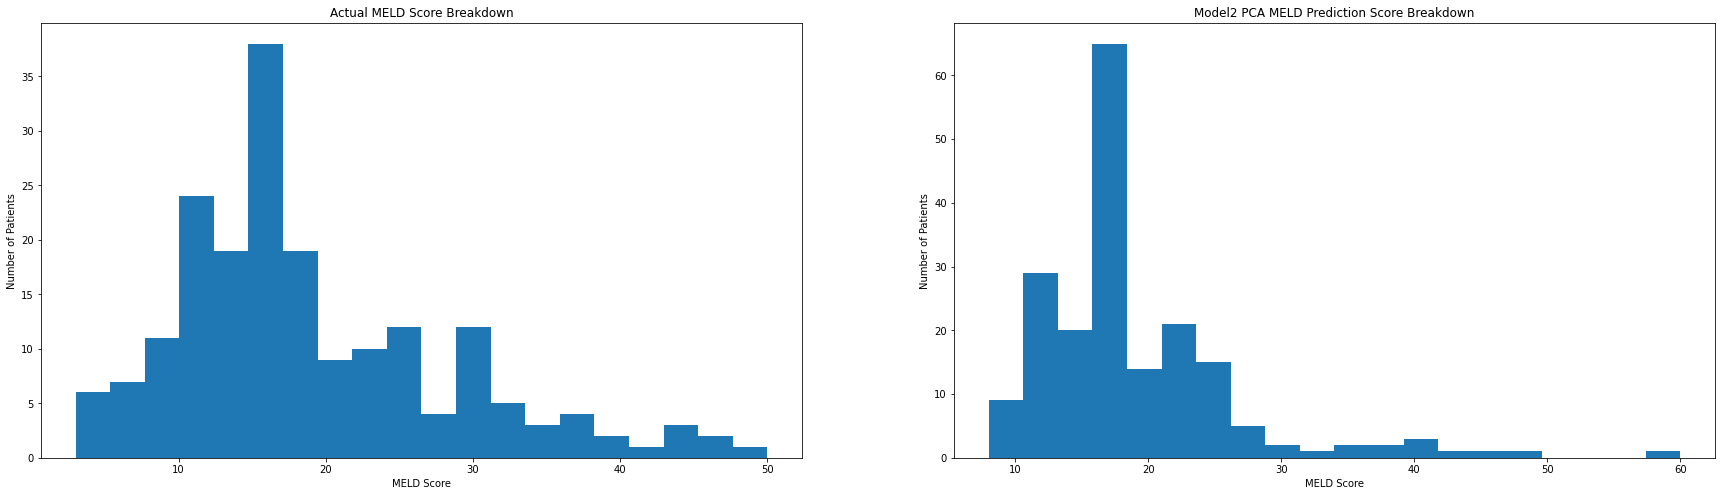

In [26]:
# MELD distribution breakdown
fig, ax = plt.subplots(1, 2, figsize=(30, 8))

ax[0].hist(np.array(y_test_pca), bins=20)
ax[0].set_title("Actual MELD Score Breakdown")
ax[0].set_xlabel("MELD Score")
ax[0].set_ylabel("Number of Patients")

ax[1].hist(y_pred_seq_pca, bins=20)
ax[1].set_title("Model2 PCA MELD Prediction Score Breakdown")
ax[1].set_xlabel("MELD Score")
ax[1].set_ylabel("Number of Patients")

In [27]:
# create meld prediction dataframe to calculate accuracies
meld_predictions_pca = pd.concat([pd.DataFrame(data=np.array(X_test_pca), columns=X_pca.columns), pd.DataFrame(data=np.array(y_pred_seq_pca), columns=["MELD_Prediction_PCA"])], axis=1)
prediction_accuracy_pca = meld_acc(meld_predictions_pca, meld_column="MELD_Prediction_PCA")

## Model 3: MELD Prediction with UMAP Dimensionality Reduction

The following model utilizes UMAP to reduce our dimensions.  UMAP reduces dimensions to 12 dimensions and uses a neighboring technique to identify features within a close distance of likeness.  We use a euclidean distance for the distance between features.  Twelve dimensions are used to closely emulate PCA, although this parameter was not optimized for this model and could be a source of model optimization n the future

In [28]:
# initialize UMAP and scale accordingly
umap_scaler = umap.UMAP(n_neighbors=10, min_dist=0.1, n_components=12, metric="euclidean", random_state=7)
scaler = StandardScaler()
X = final_df_normalized.copy(deep=True)
X = X.drop(["MELD", "MELD3", "MELDNA"], axis=1)
non_binary_cols_umap = [col for col in X.columns if len(X[col].unique()) > 2]
binary_cols_umap = [col for col in X.columns if len(X[col].unique()) <= 2]
X_non_binary_umap = pd.DataFrame(scaler.fit_transform(X[non_binary_cols_umap]), columns=non_binary_cols_umap)
X_non_binary_umap = pd.DataFrame(umap_scaler.fit_transform(X_non_binary_umap))
X_umap = pd.concat([X[binary_cols_umap], X_non_binary_umap], axis=1)

In [29]:
# split X, y
X_train_umap, X_test_umap, y_train_umap, y_test_umap = train_test_split(X_umap, y, test_size=test_size, random_state=random_state)
X_train_umap = tf.convert_to_tensor(X_train_umap)
X_test_umap = tf.convert_to_tensor(X_test_umap)
y_train_umap = tf.convert_to_tensor(y_train_umap)
y_test_umap = tf.convert_to_tensor(y_test_umap)

In [30]:
# initialize and fit sequential model
sequential_model_umap = create_sequential_model(df=X_train_umap)
sequential_model_umap.fit(x=X_train_umap,
    y=y_train_umap,
    epochs=epochs,
    verbose=verbose,
    validation_data=(X_test_umap, y_test_umap),
    batch_size=batch_size)

Text(0, 0.5, 'Loss')

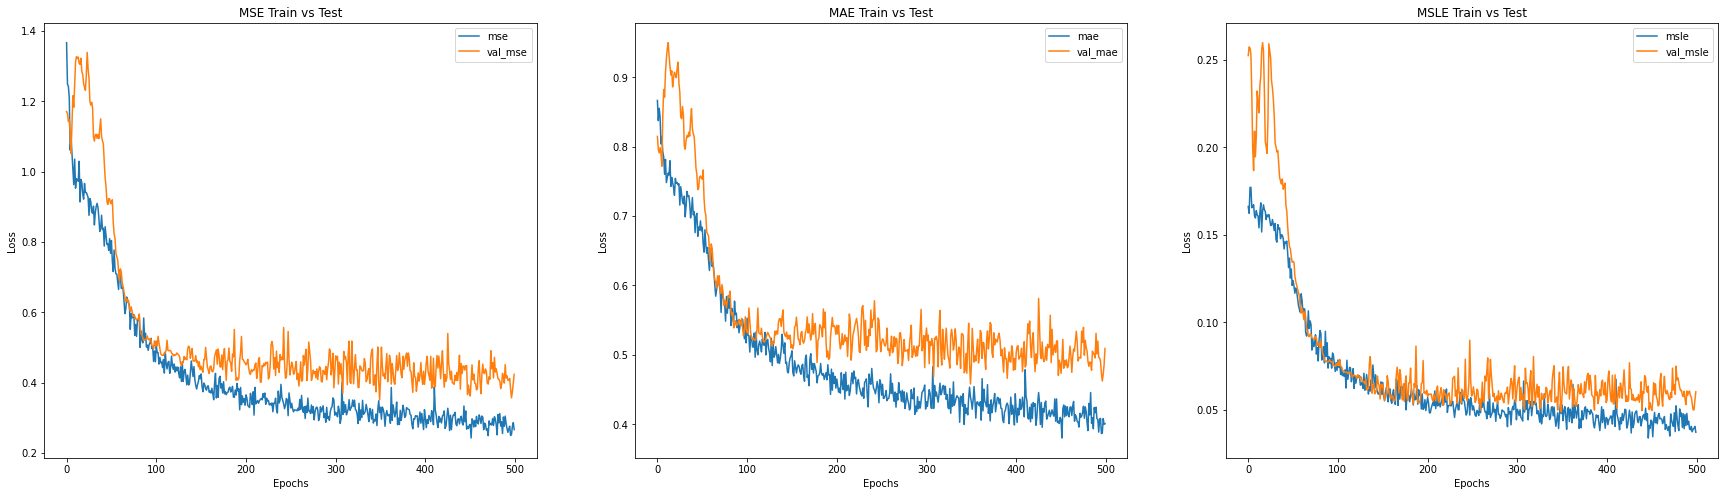

In [31]:
# plot out loss vs validation
umap_mse = sequential_model_umap.history.history["loss"]
umap_mae = sequential_model_umap.history.history["mae"]
umap_msle =  sequential_model_umap.history.history["msle"]
umap_val_mse = sequential_model_umap.history.history["val_loss"]
umap_val_mae = sequential_model_umap.history.history["val_mae"]
umap_val_msle =  sequential_model_umap.history.history["val_msle"]

fig, ax = plt.subplots(1, 3, figsize=(30, 8))
ax[0].plot(umap_mse)
ax[0].plot(umap_val_mse)
ax[0].legend(["mse", "val_mse"])
ax[0].set_title("MSE Train vs Test")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")

ax[1].plot(umap_mae)
ax[1].plot(umap_val_mae)
ax[1].legend(["mae", "val_mae"])
ax[1].set_title("MAE Train vs Test")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

ax[2].plot(umap_msle)
ax[2].plot(umap_val_msle)
ax[2].legend(["msle", "val_msle"])
ax[2].set_title("MSLE Train vs Test")
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("Loss")

In [32]:
# predict out values
y_pred_seq_umap = sequential_model_umap.predict(X_test_umap)

# reverse scaling
y_pred_seq_umap = np.round(target_scaler.inverse_transform(np.array(y_pred_seq_umap)))
y_test_umap = np.round(target_scaler.inverse_transform(np.array(y_test_umap)))

Text(0, 0.5, 'Number of Patients')

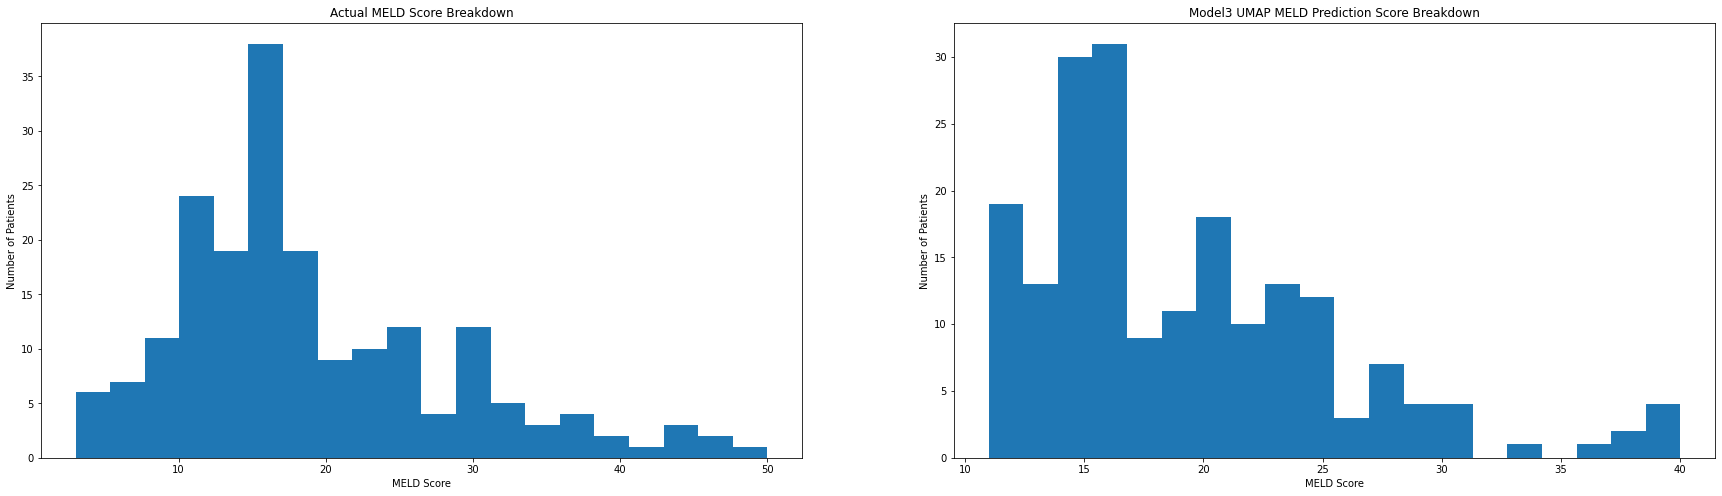

In [33]:
# MELD distribution breakdown
fig, ax = plt.subplots(1, 2, figsize=(30, 8))

ax[0].hist(np.array(y_test_umap), bins=20)
ax[0].set_title("Actual MELD Score Breakdown")
ax[0].set_xlabel("MELD Score")
ax[0].set_ylabel("Number of Patients")

ax[1].hist(y_pred_seq_umap, bins=20)
ax[1].set_title("Model3 UMAP MELD Prediction Score Breakdown")
ax[1].set_xlabel("MELD Score")
ax[1].set_ylabel("Number of Patients")

In [34]:
# create meld prediction dataframe to calculate accuracies
meld_predictions_umap = pd.concat([pd.DataFrame(data=np.array(X_test_umap), columns=X_umap.columns), pd.DataFrame(data=np.array(y_pred_seq_umap), columns=["MELD_Prediction_UMAP"])], axis=1)
prediction_accuracy_umap = meld_acc(meld_predictions_umap, meld_column="MELD_Prediction_UMAP")

## ResNet 1: A complex model example with typical data preprocessing

Our first ResNet model aims to compare itself with our first Sequential model (Model1).  We use our pre-defined res_net architecture above and train it on the same X and y datasets as Model1.  From here on out, the process remains the same as the above Sequential models, except we swap in our ResNet model.  Analysis will follow where relevant.

In [61]:
# split X, y
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X, y, test_size=test_size, random_state=random_state)
X_train_res = tf.convert_to_tensor(X_train_res)
X_test_res = tf.convert_to_tensor(X_test_res)
y_train_res = tf.convert_to_tensor(y_train_res)
y_test_res = tf.convert_to_tensor(y_test_res)

In [62]:
# initialize and fit sequential model
res_net = create_res_net(df=X_train_res)
res_net.fit(x=X_train_res,
    y=y_train_res,
    epochs=epochs,
    verbose=verbose,
    validation_data=(X_test_res, y_test_res),
    batch_size=batch_size)

We ignore the first 20 epochs as ResNet loss is highly volatile for these epochs.  This sometimes skews our graph so it's hardly legible to analyze.

Analysis: 

Text(0, 0.5, 'Loss')

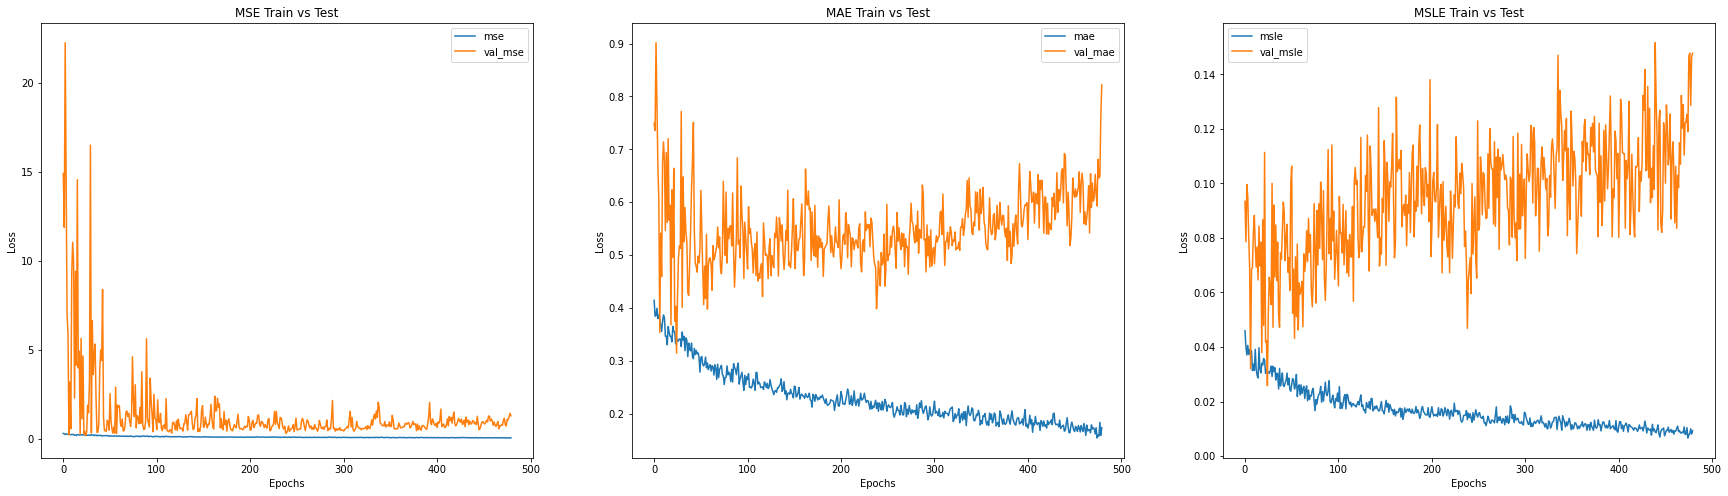

In [64]:
# plot out model 1 loss metrics
res_net_mse = res_net.history.history["loss"][20:]
res_net_mae = res_net.history.history["mae"][20:]
res_net_msle =  res_net.history.history["msle"][20:]
res_net_val_mse = res_net.history.history["val_loss"][20:]
res_net_val_mae = res_net.history.history["val_mae"][20:]
res_net_val_msle =  res_net.history.history["val_msle"][20:]

fig, ax = plt.subplots(1, 3, figsize=(30, 8))
ax[0].plot(res_net_mse)
ax[0].plot(res_net_val_mse)
ax[0].legend(["mse", "val_mse"])
ax[0].set_title("MSE Train vs Test")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")

ax[1].plot(res_net_mae)
ax[1].plot(res_net_val_mae)
ax[1].legend(["mae", "val_mae"])
ax[1].set_title("MAE Train vs Test")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

ax[2].plot(res_net_msle)
ax[2].plot(res_net_val_msle)
ax[2].legend(["msle", "val_msle"])
ax[2].set_title("MSLE Train vs Test")
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("Loss")

In [38]:
# predict out values
y_pred_res = res_net.predict(X_test_res)

# reverse scaling
y_pred_res = np.round(target_scaler.inverse_transform(np.array(y_pred_res)))
y_test_res = np.round(target_scaler.inverse_transform(np.array(y_test_res)))


ResNet1 follows similar patterns to what has been observed in the above Sequential models where the majority of higher traditional MELD scores are reclassified into lower MELD scores

Text(0, 0.5, 'Number of Patients')

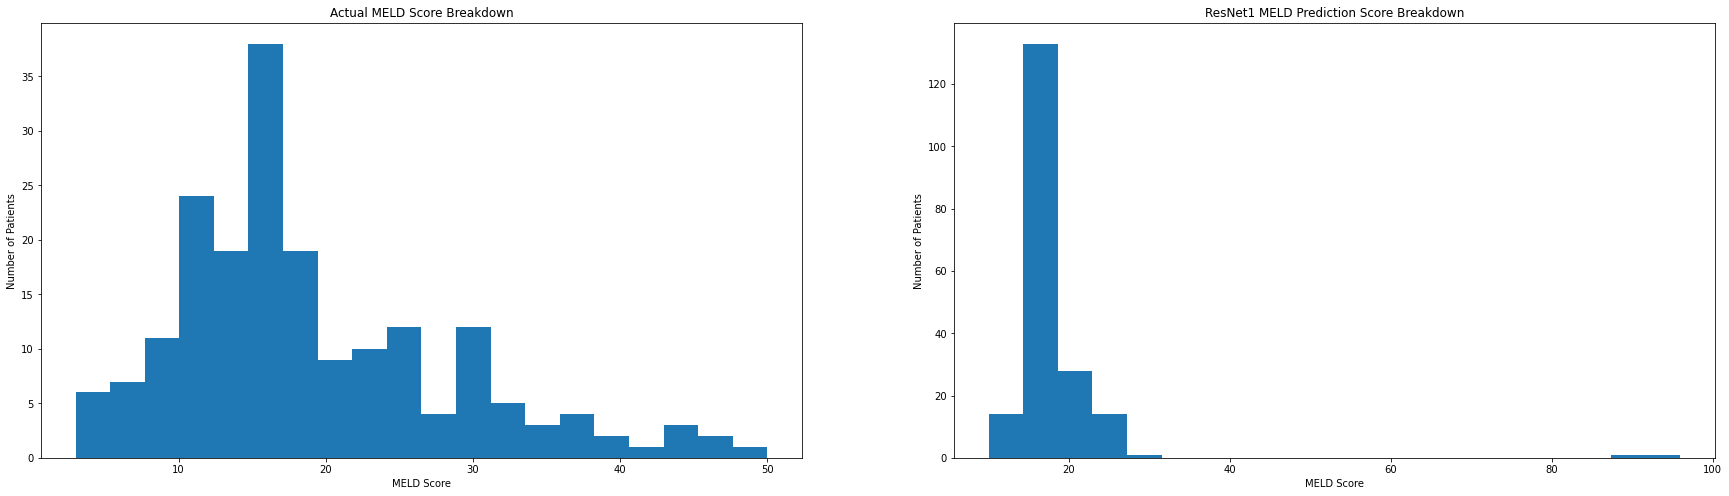

In [39]:
# MELD distribution breakdown
fig, ax = plt.subplots(1, 2, figsize=(30, 8))

ax[0].hist(np.array(y_test_res), bins=20)
ax[0].set_title("Actual MELD Score Breakdown")
ax[0].set_xlabel("MELD Score")
ax[0].set_ylabel("Number of Patients")

ax[1].hist(y_pred_res, bins=20)
ax[1].set_title("ResNet1 MELD Prediction Score Breakdown")
ax[1].set_xlabel("MELD Score")
ax[1].set_ylabel("Number of Patients")

In [40]:
# create meld prediction dataframe to calculate accuracies
meld_predictions_res = pd.concat([pd.DataFrame(data=np.array(X_test_res), columns=X.columns), pd.DataFrame(data=np.array(y_pred_res), columns=["MELD_Prediction_RN"])], axis=1)
prediction_accuracy_res = meld_acc(meld_predictions_res, meld_column="MELD_Prediction_RN")

## ResNet 2: ResNet MELD Prediction with PCA Dimensionality Reduction

Similar to the Sequential PCA, we combine ResNet with PCA dimensionality reduction.  We still use 12 PCA components as this explains ~80% of the variance

In [41]:
# split X, y
X_train_pca_res, X_test_pca_res, y_train_pca_res, y_test_pca_res = train_test_split(X_pca, y, test_size=test_size, random_state=random_state)
X_train_pca_res = tf.convert_to_tensor(X_train_pca_res)
X_test_pca_res = tf.convert_to_tensor(X_test_pca_res)
y_train_pca_res = tf.convert_to_tensor(y_train_pca_res)
y_test_pca_res = tf.convert_to_tensor(y_test_pca_res)

In [42]:
# initialize and fit sequential model
res_net_pca = create_res_net(df=X_train_pca_res)
res_net_pca.fit(x=X_train_pca_res,
    y=y_train_pca_res,
    epochs=epochs,
    verbose=0,
    validation_data=(X_test_pca_res, y_test_pca_res),
    batch_size=batch_size)

Analysis: There is apparent overfitting and by wider margins than the Sequential models above.  ResNet2 follows the similar approach to ResNet1 where overfitting

Text(0, 0.5, 'Loss')

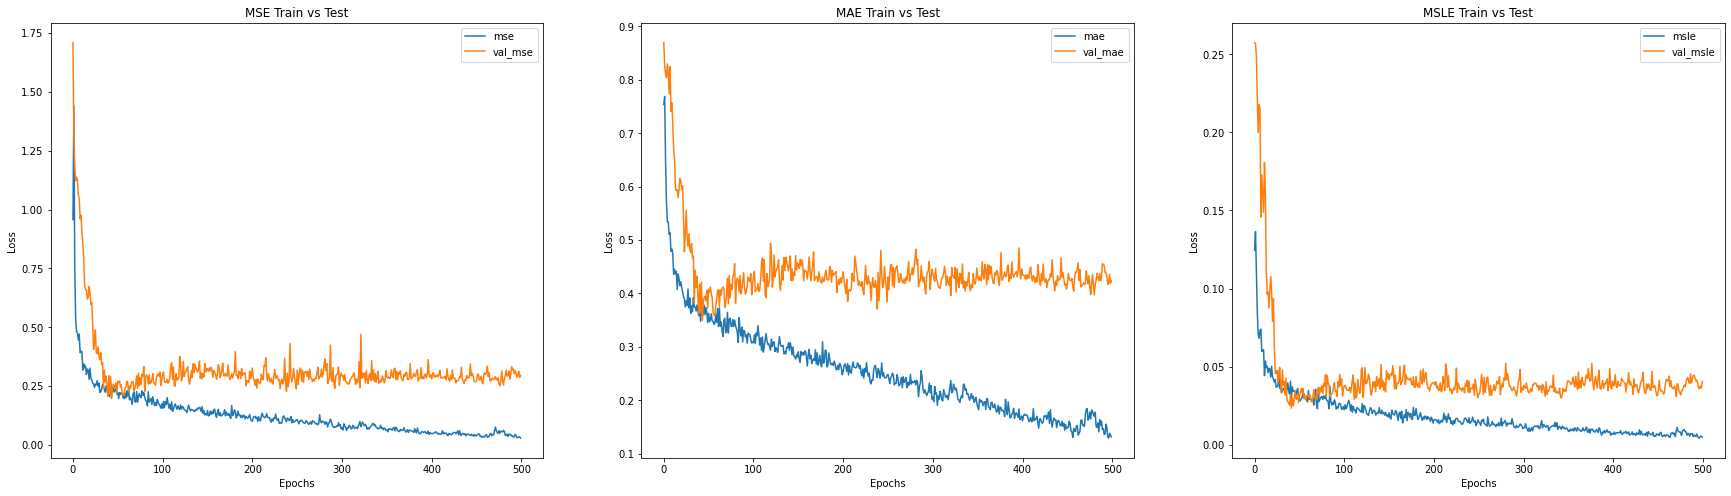

In [43]:
# plot out loss vs validation
res_net_pca_mse = res_net_pca.history.history["loss"]
res_net_pca_mae = res_net_pca.history.history["mae"]
res_net_pca_msle =  res_net_pca.history.history["msle"]
res_net_pca_val_mse = res_net_pca.history.history["val_loss"]
res_net_pca_val_mae = res_net_pca.history.history["val_mae"]
res_net_pca_val_msle =  res_net_pca.history.history["val_msle"]

fig, ax = plt.subplots(1, 3, figsize=(30, 8))
ax[0].plot(res_net_pca_mse)
ax[0].plot(res_net_pca_val_mse)
ax[0].legend(["mse", "val_mse"])
ax[0].set_title("MSE Train vs Test")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")

ax[1].plot(res_net_pca_mae)
ax[1].plot(res_net_pca_val_mae)
ax[1].legend(["mae", "val_mae"])
ax[1].set_title("MAE Train vs Test")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

ax[2].plot(res_net_pca_msle)
ax[2].plot(res_net_pca_val_msle)
ax[2].legend(["msle", "val_msle"])
ax[2].set_title("MSLE Train vs Test")
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("Loss")

In [44]:
# predict out values
y_pred_res_pca = res_net_pca.predict(X_test_pca_res)

# reverse scaling
y_pred_res_pca = np.round(target_scaler.inverse_transform(np.array(y_pred_res_pca)))
y_test_pca_res = np.round(target_scaler.inverse_transform(np.array(y_test_pca_res)))


Similar to the first model, the PCA implementation of this model also reclassifies a lot of the higher MELD scores to lower MELD scores.  More patients are reclassified between the 15 - 17 MELD range

Text(0, 0.5, 'Number of Patients')

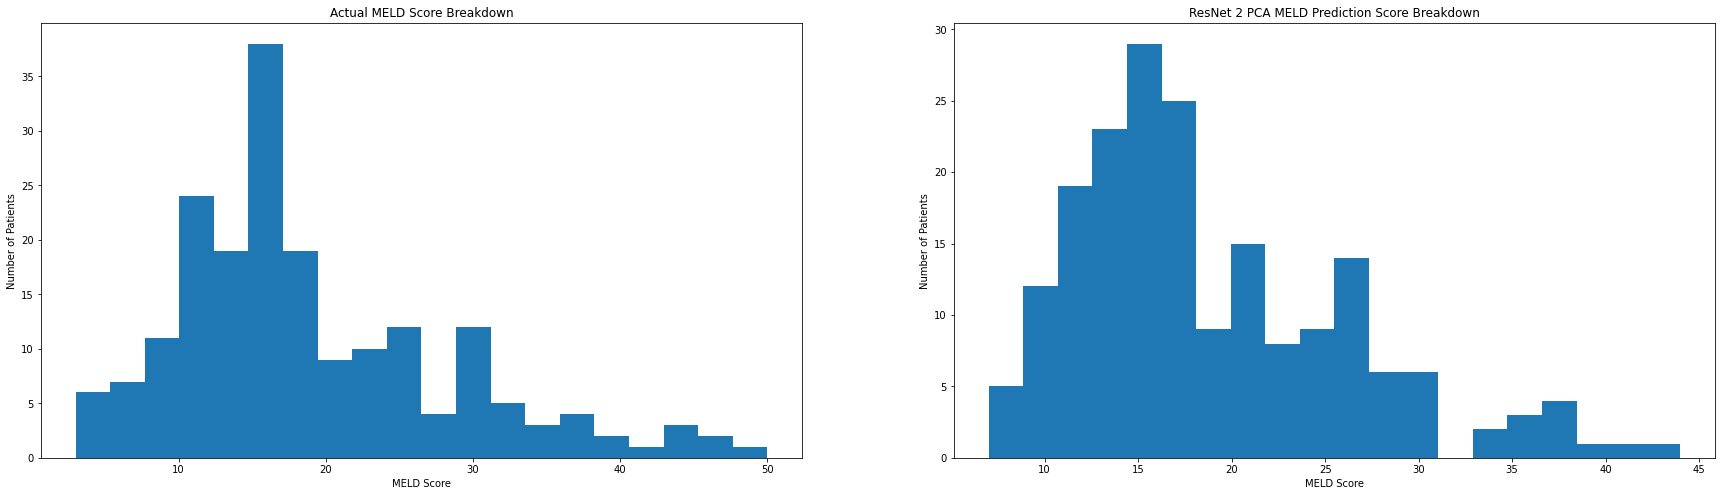

In [45]:
# MELD distribution breakdown
fig, ax = plt.subplots(1, 2, figsize=(30, 8))

ax[0].hist(np.array(y_test_pca_res), bins=20)
ax[0].set_title("Actual MELD Score Breakdown")
ax[0].set_xlabel("MELD Score")
ax[0].set_ylabel("Number of Patients")

ax[1].hist(y_pred_res_pca, bins=20)
ax[1].set_title("ResNet 2 PCA MELD Prediction Score Breakdown")
ax[1].set_xlabel("MELD Score")
ax[1].set_ylabel("Number of Patients")

In [46]:
# create meld prediction dataframe to calculate accuracies
meld_predictions_pca_res = pd.concat([pd.DataFrame(data=np.array(X_test_pca_res), columns=X_pca.columns), pd.DataFrame(data=np.array(y_pred_res_pca), columns=["MELD_Prediction_PCA_RN"])], axis=1)
prediction_accuracy_pca_res = meld_acc(meld_predictions_pca_res, meld_column="MELD_Prediction_PCA_RN")

## ResNet 3: ResNet MELD Prediction with UMAP Dimensionality Reduction

In [47]:
# split X, y
X_train_umap_res, X_test_umap_res, y_train_umap_res, y_test_umap_res = train_test_split(X_umap, y, test_size=test_size, random_state=random_state)
X_train_umap_res = tf.convert_to_tensor(X_train_umap_res)
X_test_umap_res = tf.convert_to_tensor(X_test_umap_res)
y_train_umap_res = tf.convert_to_tensor(y_train_umap_res)
y_test_umap_res = tf.convert_to_tensor(y_test_umap_res)

In [48]:
# initialize and fit sequential model
res_net_umap = create_sequential_model(df=X_train_umap_res)
res_net_umap.fit(x=X_train_umap_res,
    y=y_train_umap_res,
    epochs=epochs,
    verbose=verbose,
    validation_data=(X_test_umap_res, y_test_umap_res),
    batch_size=batch_size)

Text(0, 0.5, 'Loss')

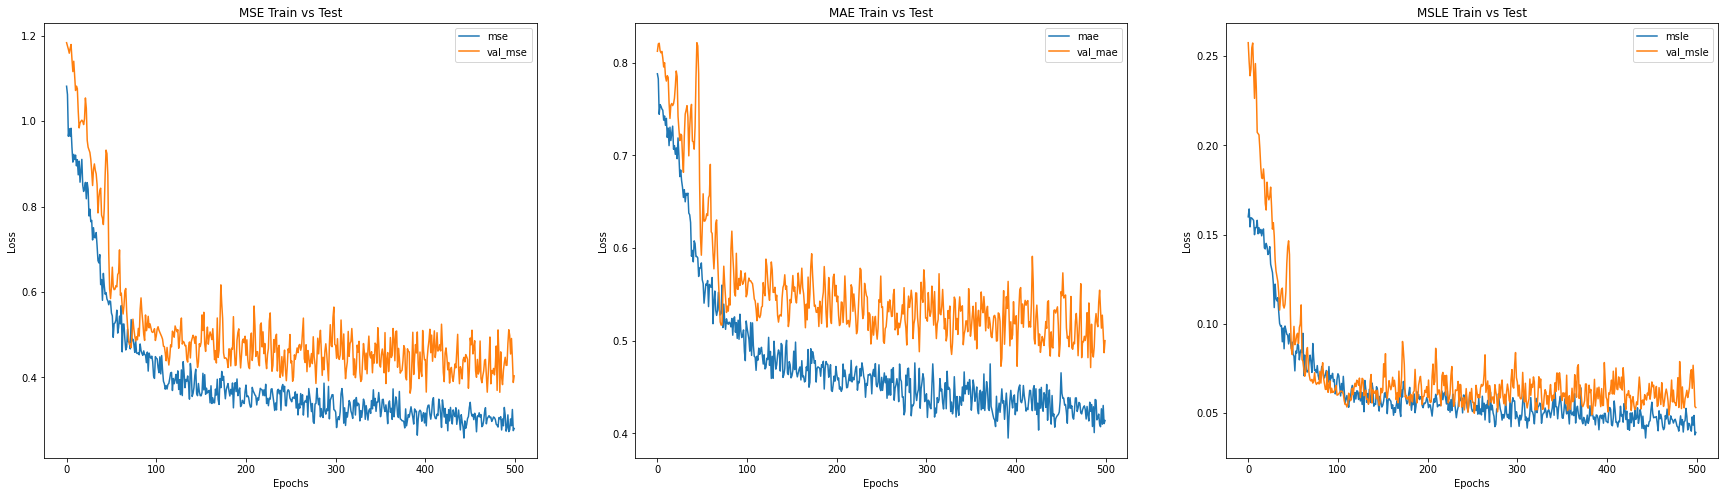

In [49]:
# plot out loss vs validation
res_net_umap_mse = res_net_umap.history.history["loss"]
res_net_umap_mae = res_net_umap.history.history["mae"]
res_net_umap_msle =  res_net_umap.history.history["msle"]
res_net_umap_val_mse = res_net_umap.history.history["val_loss"]
res_net_umap_val_mae = res_net_umap.history.history["val_mae"]
res_net_umap_val_msle =  res_net_umap.history.history["val_msle"]

fig, ax = plt.subplots(1, 3, figsize=(30, 8))
ax[0].plot(res_net_umap_mse)
ax[0].plot(res_net_umap_val_mse)
ax[0].legend(["mse", "val_mse"])
ax[0].set_title("MSE Train vs Test")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")

ax[1].plot(res_net_umap_mae)
ax[1].plot(res_net_umap_val_mae)
ax[1].legend(["mae", "val_mae"])
ax[1].set_title("MAE Train vs Test")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

ax[2].plot(res_net_umap_msle)
ax[2].plot(res_net_umap_val_msle)
ax[2].legend(["msle", "val_msle"])
ax[2].set_title("MSLE Train vs Test")
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("Loss")

In [50]:
# predict out values
y_pred_res_umap = res_net_umap.predict(X_test_umap_res)

# reverse scaling
y_pred_res_umap = np.round(target_scaler.inverse_transform(np.array(y_pred_res_umap)))
y_test_umap_res = np.round(target_scaler.inverse_transform(np.array(y_test_umap_res)))

Text(0, 0.5, 'Number of Patients')

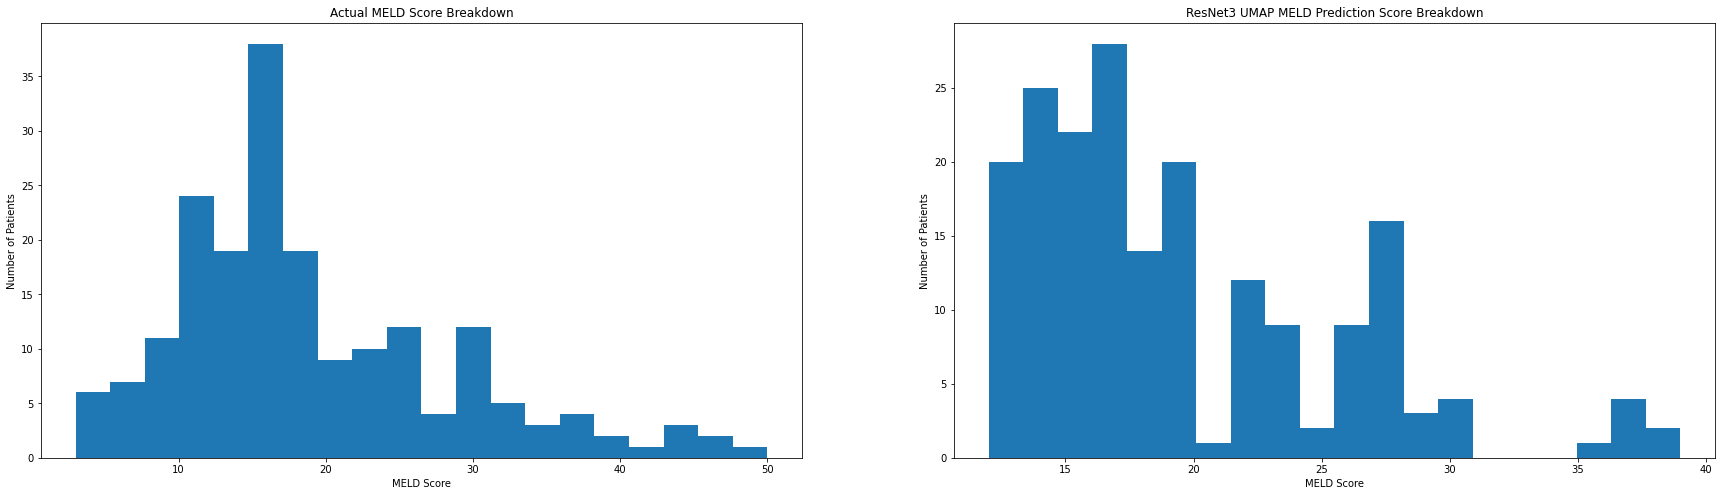

In [51]:
# MELD distribution breakdown
fig, ax = plt.subplots(1, 2, figsize=(30, 8))

ax[0].hist(np.array(y_test_umap_res), bins=20)
ax[0].set_title("Actual MELD Score Breakdown")
ax[0].set_xlabel("MELD Score")
ax[0].set_ylabel("Number of Patients")

ax[1].hist(y_pred_res_umap, bins=20)
ax[1].set_title("ResNet3 UMAP MELD Prediction Score Breakdown")
ax[1].set_xlabel("MELD Score")
ax[1].set_ylabel("Number of Patients")

In [52]:
# create meld prediction dataframe to calculate accuracies
meld_predictions_umap_res = pd.concat([pd.DataFrame(data=np.array(X_test_umap_res), columns=X_umap.columns), pd.DataFrame(data=np.array(y_pred_res_umap), columns=["MELD_Prediction_UMAP_RN"])], axis=1)
prediction_accuracy_umap_res = meld_acc(meld_predictions_umap_res, meld_column="MELD_Prediction_UMAP_RN")

## Analysis

In [53]:
# get accuracies of the calculated MELD scores within the original dataset
MELD_acc = meld_acc(final_df_normalized, meld_column="MELD")
MELD3_acc = meld_acc(final_df_normalized, meld_column="MELD3")
MELDNA_acc = meld_acc(final_df_normalized, meld_column="MELDNA")

# get each model widths
model1_width = widths(meld_predictions_seq, meld_column="MELD_Prediction_SEQ")
model2_width = widths(meld_predictions_pca, meld_column="MELD_Prediction_PCA")
model3_width = widths(meld_predictions_umap, meld_column="MELD_Prediction_UMAP")
res_net1_width = widths(meld_predictions_res, meld_column="MELD_Prediction_RN")
res_net2_width = widths(meld_predictions_pca_res, meld_column="MELD_Prediction_PCA_RN")
res_net3_width = widths(meld_predictions_umap_res, meld_column="MELD_Prediction_UMAP_RN")
meld_width = widths(final_df_normalized, meld_column="MELD")
meld3_width = widths(final_df_normalized, meld_column="MELD3")
meldna_width = widths(final_df_normalized, meld_column="MELDNA")

In [54]:
# create observability DataFrame
observability_df = pd.DataFrame(data=
    zip(["[6, 9]", "[10, 20]", "[20, 30]", "[30, 40]", "[40+]"],
    meld_width_expected,
    MELD_acc_expected,
    model1_width,
    prediction_accuracy_seq,
    model2_width,
    prediction_accuracy_pca,
    model3_width,
    prediction_accuracy_umap,
    res_net1_width,
    prediction_accuracy_res,
    res_net2_width,
    prediction_accuracy_pca_res,
    res_net3_width,
    prediction_accuracy_umap_res),
    columns = [
        "MELD Bracket",
        "Expected Deaths, n, MELD",
        "Expected Mortality Ratio, MELD",
        "Observed Deaths, n, Model1",
        "Observed Mortality Ratio, Model1",
        "Observed Deaths, n, Model2",
        "Observed Mortality Ratio, Model2",
        "Observed Deaths, n, Model3",
        "Observed Mortality Ratio, Model3",
        "Observed Deaths, n, Res_Net1",
        "Observed Mortality Ratio, Res_Net1",
        "Observed Deaths, n, Res_Net2",
        "Observed Mortality Ratio, Res_Net2",
        "Observed Deaths, n, Res_Net3",
        "Observed Mortality Ratio, Res_Net3",
    ]
    )

observability_df

,MELD Bracket,"Expected Deaths, n, MELD","Expected Mortality Ratio, MELD","Observed Deaths, n, Model1","Observed Mortality Ratio, Model1","Observed Deaths, n, Model2","Observed Mortality Ratio, Model2","Observed Deaths, n, Model3","Observed Mortality Ratio, Model3","Observed Deaths, n, Res_Net1","Observed Mortality Ratio, Res_Net1","Observed Deaths, n, Res_Net2","Observed Mortality Ratio, Res_Net2","Observed Deaths, n, Res_Net3","Observed Mortality Ratio, Res_Net3"
0,"[6, 9]",0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000
1,"[10, 20]",4,0.038095,6,0.049180,5,0.037313,2,0.016949,14,0.085890,2,0.016807,2,0.015504
2,"[20, 30]",12,0.292683,12,0.272727,16,0.390244,23,0.353846,15,0.555556,19,0.395833,24,0.428571
3,"[30, 40]",9,0.473684,9,0.642857,5,0.625000,6,0.666667,0,0.000000,8,0.666667,5,0.714286
4,[40+],6,0.857143,4,1.000000,5,0.833333,0,0.000000,2,1.000000,2,1.000000,0,0.000000


In [55]:
# scale each width
scaler = StandardScaler()
model1_width = scaler.fit_transform(np.array(model1_width).reshape(-1,1))
model1_width = list(model1_width.flatten())
model2_width = scaler.fit_transform(np.array(model2_width).reshape(-1,1))
model2_width = list(model2_width.flatten())
model3_width = scaler.fit_transform(np.array(model3_width).reshape(-1,1))
model3_width = list(model3_width.flatten())
res_net1_width = scaler.fit_transform(np.array(res_net1_width).reshape(-1,1))
res_net1_width = list(res_net1_width.flatten())
res_net2_width = scaler.fit_transform(np.array(res_net2_width).reshape(-1,1))
res_net2_width = list(res_net2_width.flatten())
res_net3_width = scaler.fit_transform(np.array(res_net3_width).reshape(-1,1))
res_net3_width = list(res_net3_width.flatten())
meld_width = scaler.fit_transform(np.array(meld_width).reshape(-1,1))
meld_width = list(meld_width.flatten())
meld3_width = scaler.fit_transform(np.array(meld3_width).reshape(-1,1))
meld3_width = list(meld3_width.flatten())
meldna_width = scaler.fit_transform(np.array(meldna_width).reshape(-1,1))
meldna_width = list(meldna_width.flatten())

Text(0, 0.5, 'Mortality Ratio')

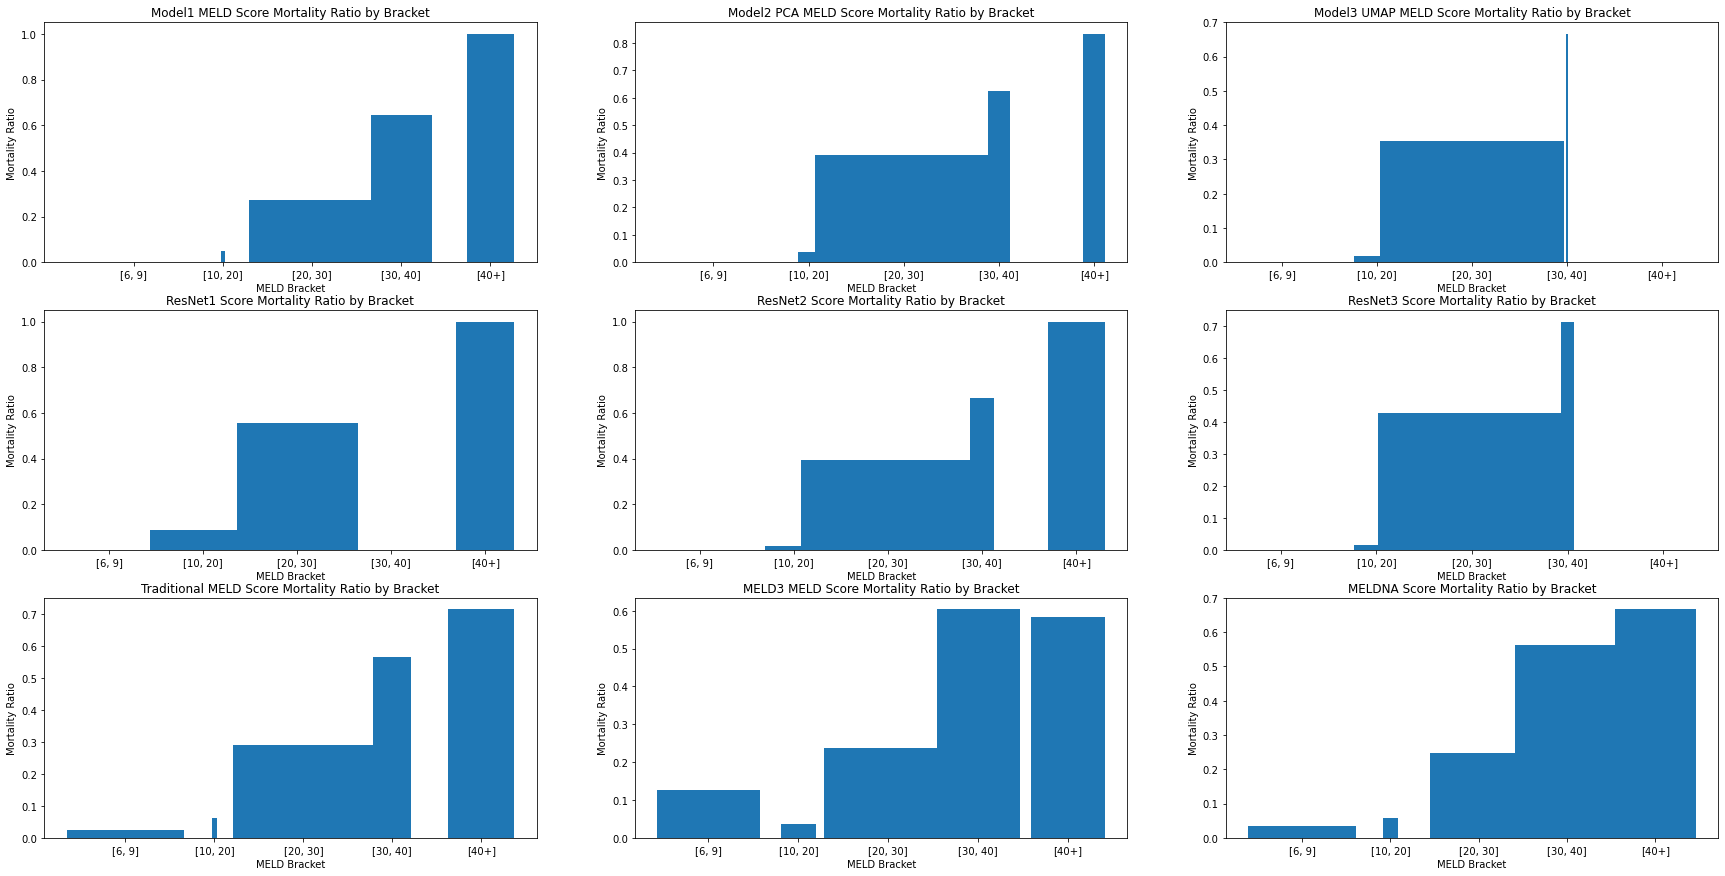

In [56]:
# plot out predictions by bracket

fig, ax = plt.subplots(3, 3, figsize=(30, 15))

ax[0,0].bar(["[6, 9]", "[10, 20]", "[20, 30]", "[30, 40]", "[40+]"], prediction_accuracy_seq, width=model1_width)
ax[0,0].set_title("Model1 MELD Score Mortality Ratio by Bracket")
ax[0,0].set_xlabel("MELD Bracket")
ax[0,0].set_ylabel("Mortality Ratio")

ax[0,1].bar(["[6, 9]", "[10, 20]", "[20, 30]", "[30, 40]", "[40+]"], prediction_accuracy_pca, width=model2_width)
ax[0,1].set_title("Model2 PCA MELD Score Mortality Ratio by Bracket")
ax[0,1].set_xlabel("MELD Bracket")
ax[0,1].set_ylabel("Mortality Ratio")

ax[0,2].bar(["[6, 9]", "[10, 20]", "[20, 30]", "[30, 40]", "[40+]"], prediction_accuracy_umap, width=model3_width)
ax[0,2].set_title("Model3 UMAP MELD Score Mortality Ratio by Bracket")
ax[0,2].set_xlabel("MELD Bracket")
ax[0,2].set_ylabel("Mortality Ratio")

ax[1,0].bar(["[6, 9]", "[10, 20]", "[20, 30]", "[30, 40]", "[40+]"], prediction_accuracy_res, width=res_net1_width)
ax[1,0].set_title("ResNet1 Score Mortality Ratio by Bracket")
ax[1,0].set_xlabel("MELD Bracket")
ax[1,0].set_ylabel("Mortality Ratio")

ax[1,1].bar(["[6, 9]", "[10, 20]", "[20, 30]", "[30, 40]", "[40+]"], prediction_accuracy_pca_res, width=res_net2_width)
ax[1,1].set_title("ResNet2 Score Mortality Ratio by Bracket")
ax[1,1].set_xlabel("MELD Bracket")
ax[1,1].set_ylabel("Mortality Ratio")

ax[1,2].bar(["[6, 9]", "[10, 20]", "[20, 30]", "[30, 40]", "[40+]"], prediction_accuracy_umap_res, width=res_net3_width)
ax[1,2].set_title("ResNet3 Score Mortality Ratio by Bracket")
ax[1,2].set_xlabel("MELD Bracket")
ax[1,2].set_ylabel("Mortality Ratio")

ax[2,0].bar(["[6, 9]", "[10, 20]", "[20, 30]", "[30, 40]", "[40+]"], MELD_acc, width=meld_width)
ax[2,0].set_title("Traditional MELD Score Mortality Ratio by Bracket")
ax[2,0].set_xlabel("MELD Bracket")
ax[2,0].set_ylabel("Mortality Ratio")

ax[2,1].bar(["[6, 9]", "[10, 20]", "[20, 30]", "[30, 40]", "[40+]"], MELD3_acc, width=meld3_width)
ax[2,1].set_title("MELD3 MELD Score Mortality Ratio by Bracket")
ax[2,1].set_xlabel("MELD Bracket")
ax[2,1].set_ylabel("Mortality Ratio")

ax[2,2].bar(["[6, 9]", "[10, 20]", "[20, 30]", "[30, 40]", "[40+]"], MELDNA_acc, width=meldna_width)
ax[2,2].set_title("MELDNA Score Mortality Ratio by Bracket")
ax[2,2].set_xlabel("MELD Bracket")
ax[2,2].set_ylabel("Mortality Ratio")

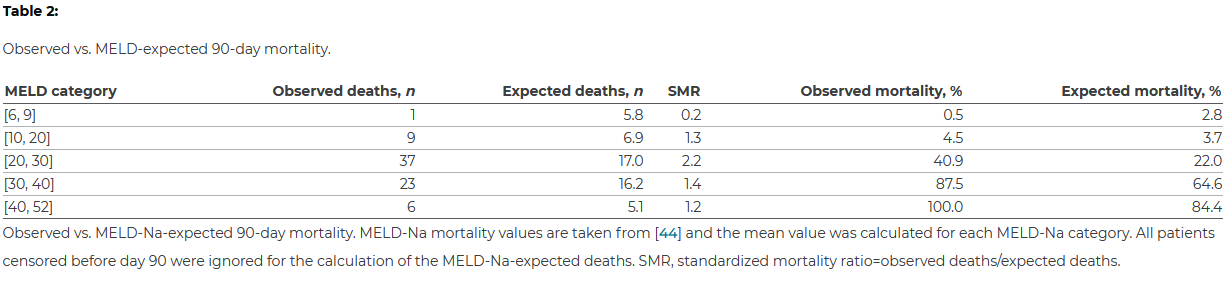

Note: Observed Mortality % is the model prediction, Expected is the baseline to measure against

## Test for Significance

In [57]:
# set significance level
alpha = 0.05

# calculate critical t-value
t_critical = t.ppf(q=1-alpha/2, df=len(y_pred_seq))

print("Critical t-value:", t_critical)
print("Range of Significance:", -t_critical, t_critical)

Critical t-value: 1.9723964913127592
Range of Significance: -1.9723964913127592 1.9723964913127592


In [58]:
seq_model1_model2 = ttest_rel(y_pred_seq, y_pred_seq_pca)
seq_model1_model3 = ttest_rel(y_pred_seq, y_pred_seq_umap)
seq_model2_model3 = ttest_rel(y_pred_seq_pca, y_pred_seq_umap)

res_net1_res_net2 = ttest_rel(y_pred_res, y_pred_res_pca)
res_net1_res_net3 = ttest_rel(y_pred_res, y_pred_res_umap)
res_net2_res_net3 = ttest_rel(y_pred_res_pca, y_pred_res_umap)

seq_model1_res_net1 = ttest_rel(y_pred_seq, y_pred_res)
seq_model1_res_net2 = ttest_rel(y_pred_seq, y_pred_res_pca)
seq_model1_res_net3 = ttest_rel(y_pred_seq, y_pred_res_umap)
seq_model2_res_net1 = ttest_rel(y_pred_seq_pca, y_pred_res)
seq_model2_res_net2 = ttest_rel(y_pred_seq_pca, y_pred_res_pca)
seq_model2_res_net3 = ttest_rel(y_pred_seq_pca, y_pred_res_umap)
seq_model3_res_net1 = ttest_rel(y_pred_seq_umap, y_pred_res)
seq_model3_res_net2 = ttest_rel(y_pred_seq_umap, y_pred_res_pca)
seq_model3_res_net3 = ttest_rel(y_pred_seq_umap, y_pred_res_umap)


In [59]:
print(f"Model1, Model2 T-Statistic: {seq_model1_model2[0][0]}, p-value: {seq_model1_model2[1][0]}")
print(f"Model1, Model3 T-Statistic: {seq_model1_model3[0][0]}, p-value: {seq_model1_model3[1][0]}")
print(f"Model2, Model3 T-Statistic: {seq_model2_model3[0][0]}, p-value: {seq_model2_model3[1][0]}")

print(f"ResNet1, ResNet2 T-Statistic: {res_net1_res_net2[0][0]}, p-value: {res_net1_res_net2[1][0]}")
print(f"ResNet1, ResNet3 T-Statistic: {res_net1_res_net3[0][0]}, p-value: {res_net1_res_net3[1][0]}")
print(f"ResNet2, ResNet3 T-Statistic: {res_net2_res_net3[0][0]}, p-value: {res_net2_res_net3[1][0]}")

print(f"Model1, ResNet1 T-Statistic: {seq_model1_res_net1[0][0]}, p-value: {seq_model1_res_net1[1][0]}")
print(f"Model1, ResNet2 T-Statistic: {seq_model1_res_net2[0][0]}, p-value: {seq_model1_res_net2[1][0]}")
print(f"Model1, ResNet3 T-Statistic: {seq_model1_res_net3[0][0]}, p-value: {seq_model1_res_net3[1][0]}")

print(f"Model2, ResNet1 T-Statistic: {seq_model2_res_net1[0][0]}, p-value: {seq_model2_res_net1[1][0]}")
print(f"Model2, ResNet2 T-Statistic: {seq_model2_res_net2[0][0]}, p-value: {seq_model2_res_net2[1][0]}")
print(f"Model2, ResNet3 T-Statistic: {seq_model2_res_net3[0][0]}, p-value: {seq_model2_res_net3[1][0]}")

print(f"Model3, ResNet1 T-Statistic: {seq_model3_res_net1[0][0]}, p-value: {seq_model3_res_net1[1][0]}")
print(f"Model3, ResNet2 T-Statistic: {seq_model3_res_net2[0][0]}, p-value: {seq_model3_res_net2[1][0]}")
print(f"Model3, ResNet3 T-Statistic: {seq_model3_res_net3[0][0]}, p-value: {seq_model3_res_net3[1][0]}")


Model1, Model2 T-Statistic: 0.34504334198418296, p-value: 0.7304414560981713
Model1, Model3 T-Statistic: -0.7416446222366804, p-value: 0.4592136288786284
Model2, Model3 T-Statistic: -0.9903238304988212, p-value: 0.3232687749916744
ResNet1, ResNet2 T-Statistic: -0.5806340112814776, p-value: 0.5621715837501722
ResNet1, ResNet3 T-Statistic: -1.7433607217498086, p-value: 0.0828797433828266
ResNet2, ResNet3 T-Statistic: -2.552096919168345, p-value: 0.011490013248312466
Model1, ResNet1 T-Statistic: 1.0344513942822775, p-value: 0.30223315711484444
Model1, ResNet2 T-Statistic: 0.863985321144254, p-value: 0.388679656848232
Model1, ResNet3 T-Statistic: -1.549564773742779, p-value: 0.12290136654849296
Model2, ResNet1 T-Statistic: 0.8475581510545154, p-value: 0.39774489962731285
Model2, ResNet2 T-Statistic: 0.6070044258512172, p-value: 0.5445688630995449
Model2, ResNet3 T-Statistic: -1.825851041010992, p-value: 0.06943423689122691
Model3, ResNet1 T-Statistic: 1.3048492598063473, p-value: 0.1935140